In [14]:
from tqdm import tqdm

import torch
import torch.nn as nn
from src.model import GraphTransformer
from torch_ema import ExponentialMovingAverage
from src.diffusion import SDE


device = torch.device('cuda:1')

n_layers = 6
input_dims = {'X': 4, 'E': 1, 'y': 1}
hidden_mlp_dims = {'X': 256, 'E': 128, 'y': 128}
hidden_dims = {'dx': 256, 'de': 64, 'dy': 64, 'n_head': 8, 'dim_ffX': 256, 'dim_ffE': 128, 'dim_ffy': 128}
output_dims = {'X': 4, 'E': 1, 'y': 1}


model = GraphTransformer(
        n_layers=n_layers,
        input_dims=input_dims,
        hidden_mlp_dims=hidden_mlp_dims,
        hidden_dims=hidden_dims,
        output_dims=output_dims,
        act_fn_in=nn.ReLU(),
        act_fn_out=nn.ReLU(),
    ).to(device)
sde = SDE().to(device)

model.load_state_dict(torch.load('ckpts/qm9_test_50epochs.pt'))

n_atoms = torch.randint(1, 10, (8, ))
samples = sde.euler_maruyama_sample(model, device, n_atoms=n_atoms, n_steps=500)
#samples = sde.predictor_corrector_sample(model, device, n_atoms=n_atoms, n_steps=1000, n_lang_steps=3)

torch.Size([8, 8, 4]) torch.Size([8, 8, 8]) torch.Size([8, 8])


100%|██████████| 500/500 [00:30<00:00, 16.51it/s]


In [1]:
from src.data_utils import get_n_atom_distribution

from src.datasets.qm9_dataset import QM9Dataset
import pandas as pd


df = pd.read_csv('../../data/qm9.csv')
dataset = QM9Dataset(df['smiles'].tolist())
train_data_dist = get_n_atom_distribution(dataset)
train_data_dist

100%|██████████| 133885/133885 [01:39<00:00, 1343.88it/s]


tensor([0.0000e+00, 2.2407e-05, 3.7345e-05, 6.7222e-05, 2.3154e-04, 9.7098e-04,
        4.6159e-03, 2.3879e-02, 1.3667e-01, 8.3351e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])

In [4]:
train_data_dist[1]

tensor(2.2407e-05)

In [18]:
import torch
torch.multinomial(train_data_dist, 8, replacement=True)

tensor([9, 8, 9, 9, 8, 9, 9, 9])

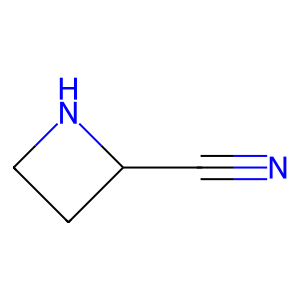

In [29]:
from src.data_utils import drop_masked, data_to_mol, mol_to_pil, valid_mol_to_pil


X, E = samples

i = 6

x, e = drop_masked(X[i], E[i])
mol = data_to_mol(x, e)
valid_mol_to_pil(mol)

In [104]:
x.argmax(-1)

tensor([0, 2, 0, 1, 0, 2, 0, 1, 0], device='cuda:1')

In [107]:
torch.round(e * 4)

tensor([[0., 0., 0., 0., 0., -0., 1., 0., -0.],
        [0., 0., 1., -0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 1., 0., 1., -0.],
        [0., -0., 0., 0., 1., 0., 1., -0., 3.],
        [0., 0., 0., 1., 0., 1., 0., 1., 1.],
        [-0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 1., -0.],
        [0., 0., 1., -0., 1., 0., 1., 0., -0.],
        [-0., 1., -0., 3., 1., 0., -0., -0., 0.]], device='cuda:1')